In [316]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import os
from copy import deepcopy
from statsmodels.tsa import exponential_smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import OneHotEncoder
from fbprophet import Prophet

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

import warnings
import pmdarima as pm
import yfinance as yf
plt.style.use('seaborn-whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

В качестве данных будут взяты дневные(цены закрытия) ао Сбер, диапозон дат: 2019-01-03 : 2022-01-12 <br>
training set : 2019-01-03 : 2022-11-30
test set : 2021-12-01 : 2022-01-12
<br>
В работе для обучения моделей будет использовано скользящее окно размером 734 измерения, с горизонтом прогнозирования 1 день. Прогнозирование будет производится на 29 дней, с переобучением моделей после получения каждого нового значения.
Финальный прогноз представляет из себя среднее арифметическое значение предсказаний моделей<br>
В работе используются модели: эксп.сглаживание, prophet, LinearReg, XGBoost, LR+XGBoost, Arima<br>
Используемые метрки: MAPE, MAE, MSE, R2

In [2]:
# data_y =  yf.download("SBERP.ME", start="2019-01-03", end="2022-01-12")

In [84]:
os.chdir('C:\\Users\\ruden\\Desktop')  #workspace
data = pd.read_csv('SBER.ME.csv',usecols=[0,4]) 

In [87]:
data.head()

,Date,Close
0,2019-01-03,186.990005
1,2019-01-04,190.990005
2,2019-01-08,191.240005
3,2019-01-09,197.000000
4,2019-01-10,196.750000


In [62]:
data.Date = pd.to_datetime(data.Date)
data['Day of week'] = data.Date.dt.day_of_week

In [63]:
ohe = OneHotEncoder(sparse=False) #ohe для дней недели

In [64]:
days_ = pd.DataFrame(
    ohe.fit_transform(data['Day of week'].to_numpy().reshape(-1, 1)),
    index=data.index,
    columns=['Monday', 'Tuesday', 'Wednesday', 'Thuesday', 'Friday'],
    
)
# pd.get_dummies(data['Day of week'])

In [65]:
data = pd.concat([data, days_], axis=1)
data.drop(['Day of week'], inplace=True, axis=1)

In [66]:
mov_avg = data.Close.rolling(window=10).mean() # тренд с помощью MA и 2хMA
mov_avg_x2 = mov_avg.rolling(window=5).mean()

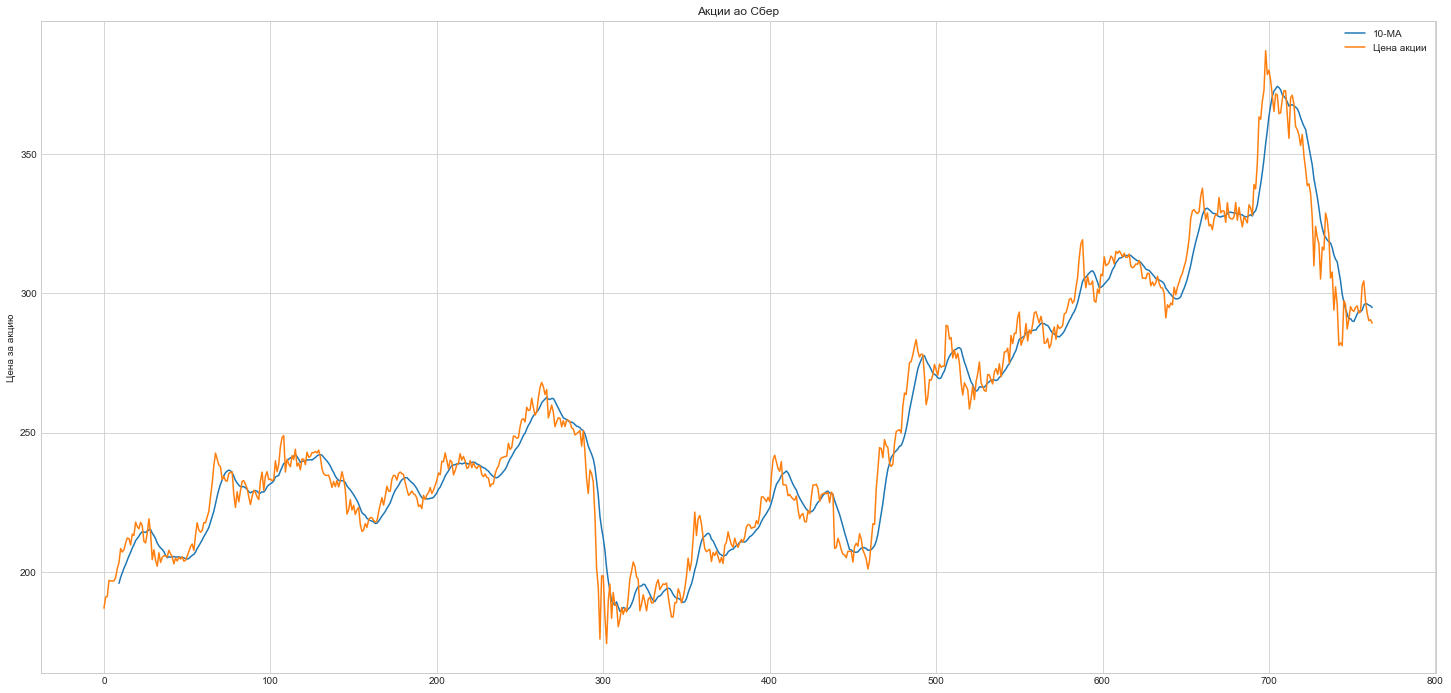

In [67]:
plt.figure(figsize=(25,12))
plt.plot(mov_avg, label='10-MA')
# plt.plot(mov_avg_x2, '--', label='5x10-MA')
plt.plot(data.Close, label='Цена акции')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');
plt.grid(True)

In [71]:
train_lenght = 734
train_data = data.iloc[0: train_lenght]
test_data = data.iloc[train_lenght:]

In [106]:
predictions_ = pd.DataFrame({'Close' : test_data.Close.values})

# Экспоненциальное сглаживание, модель Хольта-Винтерса

In [414]:
model_ETS = ExponentialSmoothing(train_data.Close, seasonal_periods=5, trend='additive', damped_trend=True).fit()

In [125]:
ETS_predict = list()
for i in range(len(test_data)):
    model_ETS = ExponentialSmoothing(data.iloc[i:train_lenght + i,1], seasonal_periods=5, trend='additive', damped_trend=True).fit()
    fitted_ = model_ETS.predict(i, train_lenght + i - 1)
    ETS_predict.append(fitted_.iloc[-1]) 

In [129]:
predictions_['EXP'] = ETS_predict

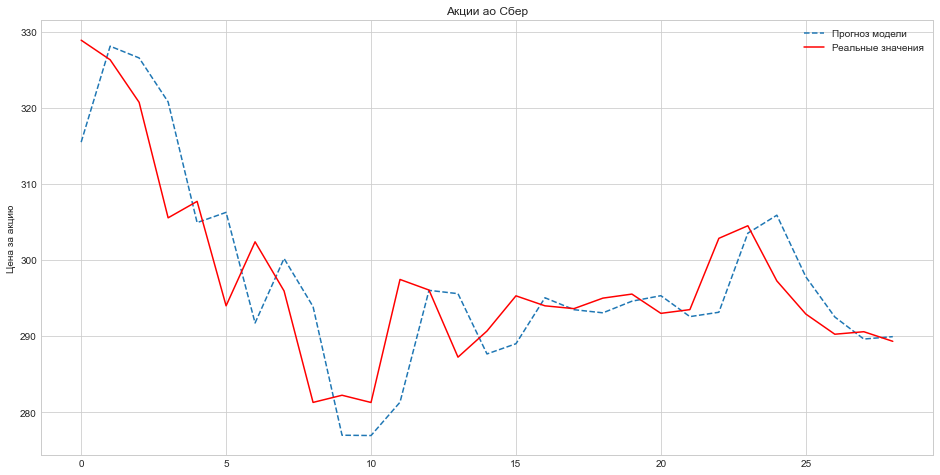

In [128]:
plt.figure(figsize=(16,8))
plt.plot(ETS_predict, '--', label='Прогноз модели')
plt.plot(test_data.Close.values, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [317]:
exp_smoothing_err = [mean_absolute_percentage_error(test_data.Close.values, ETS_predict), \
                    mean_absolute_error(test_data.Close.values, ETS_predict), \
                    mean_squared_error(test_data.Close.values, ETS_predict), \
                    r2_score(test_data.Close.values, ETS_predict)]
# exp_smoothing_forecast = [*fitted_[-horizon_:]]

# Prophet

In [90]:
data_prophet = train_data.iloc[:,0:2].copy()
data_prophet.columns = ['ds', 'y']

In [149]:
PROPHET_predict = list()
for i in range(len(test_data)):
    data_prophet = train_data.iloc[i:train_lenght + i,0:2].copy()
    data_prophet.columns = ['ds', 'y']
    model_prophet = Prophet(n_changepoints=50,
                        weekly_seasonality=True,
                        yearly_seasonality=True,
                        daily_seasonality=False,
                        seasonality_mode='additive'
                       )
    model_prophet.fit(data_prophet);
    prophet_forecast_df = model_prophet.make_future_dataframe(periods=1)
    prophet_forecast = model_prophet.predict(prophet_forecast_df)
    PROPHET_predict.append(prophet_forecast['yhat'].iloc[-1])

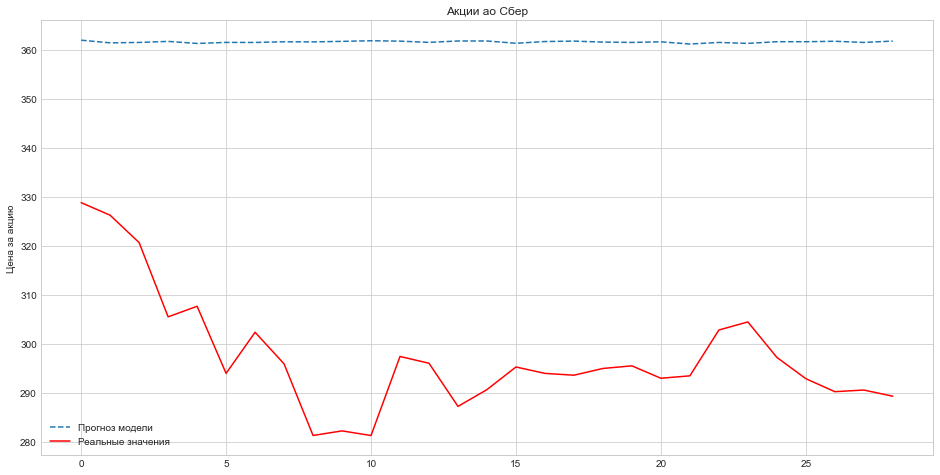

In [151]:
plt.figure(figsize=(16,8))
plt.plot(PROPHET_predict, '--', label='Прогноз модели')
plt.plot(test_data.Close.values, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [320]:
prophet_err = [mean_absolute_percentage_error(test_data.Close.values, PROPHET_predict), \
                    mean_absolute_error(test_data.Close.values, PROPHET_predict), \
                    mean_squared_error(test_data.Close.values, PROPHET_predict),\
                    r2_score(test_data.Close.values, PROPHET_predict)]


# Linear Regression

In [212]:
data_LR = data.copy()
data_LR.head()

,Date,Close
0,2019-01-03,186.990005
1,2019-01-04,190.990005
2,2019-01-08,191.240005
3,2019-01-09,197.000000
4,2019-01-10,196.750000


In [213]:
for i in range(1, 3):
    data_LR[f'ylag {i}'] = data_LR.Close.shift(i)

In [214]:
data_LR.dropna(inplace=True)

In [215]:
dp = DeterministicProcess(
    index=data_LR.index,  
    constant=True,       
    order=3,            
    drop=True,           
)
#тренд кусочно-линейный, пробовал разные порядки, со значение 3 оказался лучший вариант
X = dp.in_sample()

In [216]:
y = data_LR.Close

In [217]:
X = pd.concat([X, data_LR.iloc[:,2:]], sort=False, axis=1)

In [218]:
LR_predict = list()
for i in range(len(test_data)):
    model_LR = LinearRegression(fit_intercept=False, n_jobs=1000)
    model_LR.fit(X.iloc[i:train_lenght + i,:], y.iloc[i:train_lenght+i])
    y_pred = model_LR.predict(X.iloc[i:train_lenght + i + 1,:])
    LR_predict.append(y_pred[-1])

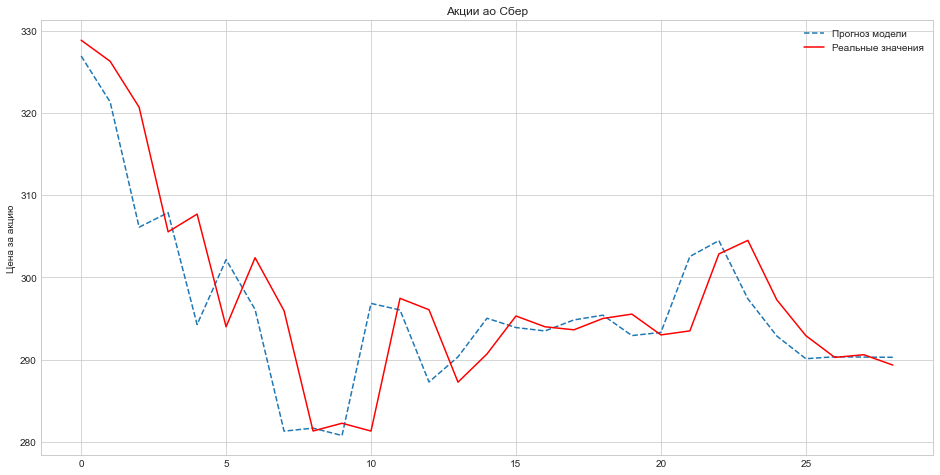

In [219]:
plt.figure(figsize=(16,8))
plt.plot(LR_predict, '--', label='Прогноз модели')
plt.plot(test_data.Close.values, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [321]:
LR_err = [mean_absolute_percentage_error(test_data.Close.values, LR_predict), \
                    mean_absolute_error(test_data.Close.values, LR_predict), \
                    mean_squared_error(test_data.Close.values, LR_predict), \
                    r2_score(test_data.Close.values, LR_predict)]

# Xgboost

In [263]:
data_xgb = data.copy()

In [264]:
for i in range(1, 3):
    data_xgb[f'ylag {i}'] = data_xgb.Close.shift(i)

In [265]:
dp = DeterministicProcess(
    index=data_LR.index,  
    constant=True,       
    order=2,            
    drop=True,           
)

X = dp.in_sample()

In [266]:
data_xgb.dropna(inplace=True)

In [267]:
y = data_LR.Close
X = pd.concat([X, data_xgb.iloc[:,2:]], sort=False, axis=1)

In [268]:
XGB_predict = list()
for i in range(len(test_data)):
    model_XGB = XGBRegressor()
    model_XGB.fit(X.iloc[i:train_lenght+i,:], y.iloc[i:train_lenght+i])
    XGB_predict.append(model_XGB.predict(X.iloc[i:train_lenght+i+1,:])[-1])
    

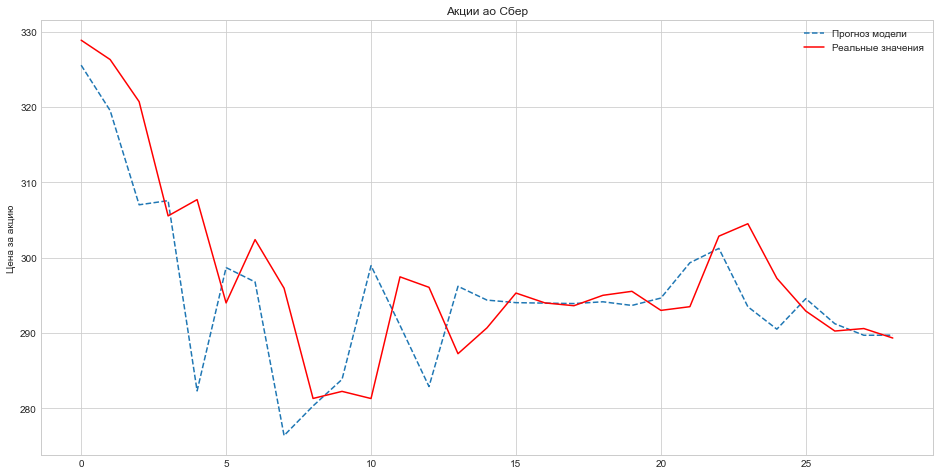

In [269]:
plt.figure(figsize=(16,8))
plt.plot(XGB_predict, '--', label='Прогноз модели')
plt.plot(test_data.Close.values, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [322]:
xgb_err = [mean_absolute_percentage_error(test_data.Close.values, XGB_predict), \
                    mean_absolute_error(test_data.Close.values, XGB_predict), \
                    mean_squared_error(test_data.Close.values, XGB_predict), \
                    r2_score(test_data.Close.values, XGB_predict)]

# Гибридные модели

С помощью обычной линейной регрессии получаю тренд, после чего обучаю xgboost на остатках <br>
    y_pred = y_LR + y_XGB

In [261]:
data_hybrid = data.copy()

In [272]:
HYBRID_predict = list()
for i in range(len(test_data)):
    model_p1 = LinearRegression()
    model_p1.fit(X.iloc[i:train_lenght+i,:], y.iloc[i:train_lenght+i])
    p1 = model_p1.predict(X.iloc[i:train_lenght+i,:])
    model_p2 = XGBRegressor()
    model_p2.fit(X.iloc[i:train_lenght+i,:], y.iloc[i:train_lenght+i] - p1)
    y_pred_hybrid = model_p1.predict(X.iloc[i:train_lenght+i+1]) + model_p2.predict(X.iloc[i:train_lenght+i+1])
    HYBRID_predict.append(y_pred_hybrid[-1])

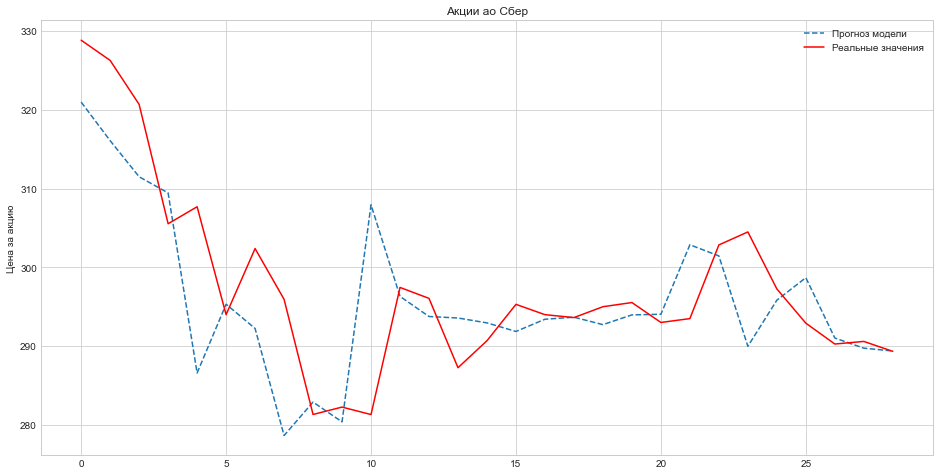

In [274]:
plt.figure(figsize=(16,8))
plt.plot(HYBRID_predict, '--', label='Прогноз модели')
plt.plot(test_data.Close.values, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [323]:
hybrid_err = [mean_absolute_percentage_error(test_data.Close.values, HYBRID_predict), \
                    mean_absolute_error(test_data.Close.values, HYBRID_predict), \
                    mean_squared_error(test_data.Close.values, HYBRID_predict), \
                    r2_score(test_data.Close.values, HYBRID_predict)]

# Модели класса ARMA

In [279]:
data_arma = data.copy()

In [280]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data_arma.Close))[1])
print('Гипотеза нестацонарности ряда не отвергнута')

Критерий Дики-Фуллера: p=0.482528
Гипотеза нестацонарности ряда не отвергнута


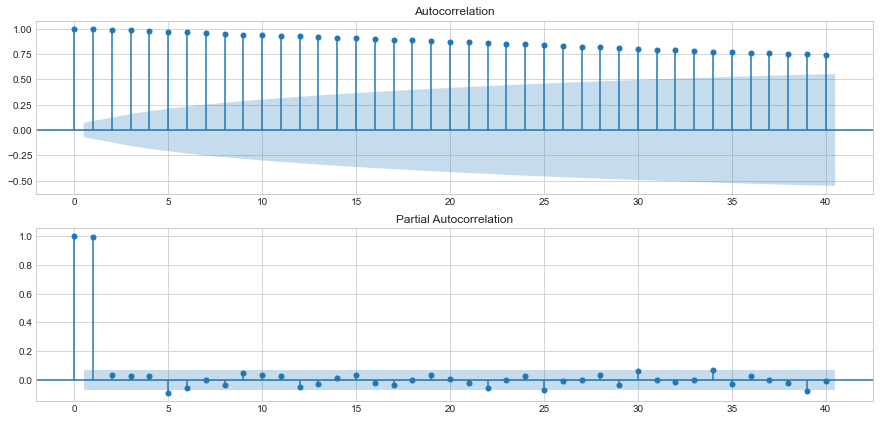

In [281]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plot_acf(data_arma.Close, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(data_arma.Close, method='ywmle', lags=40, ax=plt.gca())
plt.show()

Используем преобразование Бокса-Кокса

In [282]:
data_arma_diff = data_arma.Close.diff(periods=1).dropna()

In [283]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_arma_diff)[1])
print('Получаем стационарный ряд, в нашей будущей модели d=1')

Критерий Дики-Фуллера: p=0.000000
Получаем стационарный ряд, в нашей будущей модели d=1


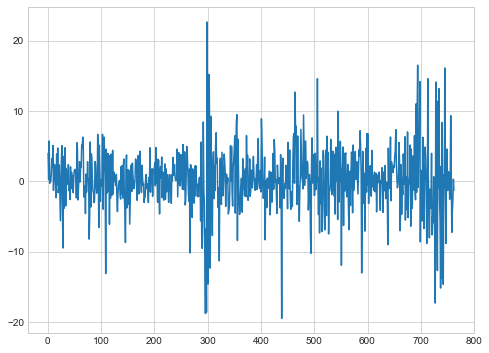

In [284]:
plt.figure(figsize=(8,6))
data_arma_diff.plot();

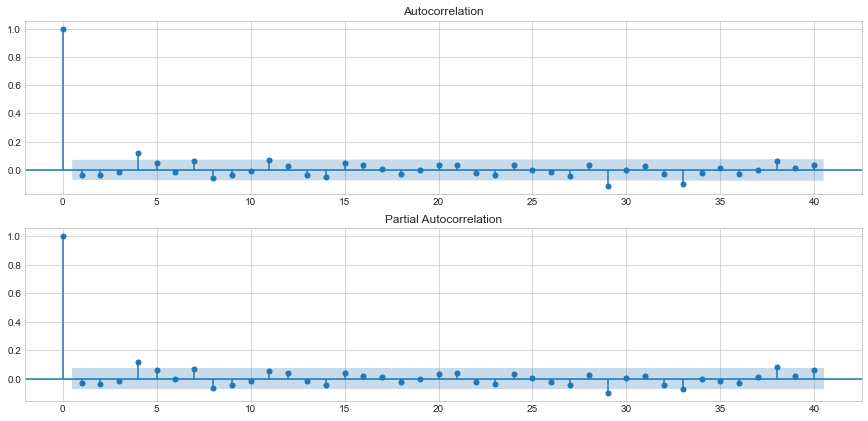

In [285]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plot_acf(data_arma_diff, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(data_arma_diff, method='ywmle', lags=40, ax=plt.gca())
plt.show()

In [286]:
train_data = data_arma.iloc[0: train_lenght]
test_data = data_arma.iloc[train_lenght:]

In [335]:
ARIMA_predict = list()
for i in range(len(test_data)):
    model_arma = pm.auto_arima(data_arma.iloc[i:train_lenght+i,1], start_p=0, d=1,start_q=0,max_p=5, max_d=5, max_q=5,
                           start_P=0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5, trace=True, stepwise=True)
    ARIMA_predict.append(*model_arma.predict(n_periods=1))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4218.027, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4219.320, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4219.249, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4217.255, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4220.933, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4226.407, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4227.656, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4227.596, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4225.801, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4229.348, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.297 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4226.816, Time=

In [300]:
# model_arma.summary()

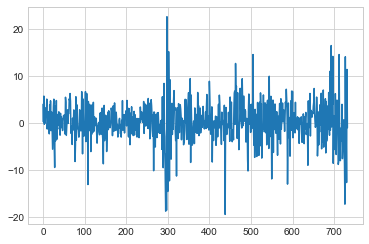

In [289]:
# plt.plot(model_arma.resid()[1:]); #график остатков модели

In [301]:
# print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model_arma.resid(), 0)[1])
# print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model_arma.resid())[1])

С помощью критерия Стьюдента произведено тестирование гипотезы не смещенности ошибки, которую не отвергли - ошибка не смещана, с помощью критерия Дики-Фулера произведена проверка гипотезы нестационарности, которая была отвергнута, т.е. ряд стационарный <br>
Данные тесты показывают то что наша модель оптимальна, в остатках больше нет никакой полезной информации для прогноза

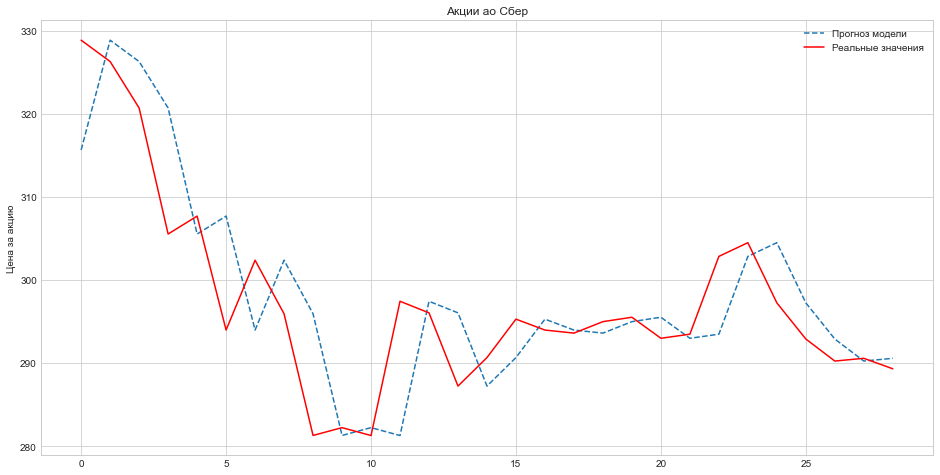

In [336]:
plt.figure(figsize=(16,8))
plt.plot(ARIMA_predict, '--', label='Прогноз модели')
plt.plot(test_data.Close.values, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [324]:
arma_err = [mean_absolute_percentage_error(test_data.Close.values, ARIMA_predict), \
                    mean_absolute_error(test_data.Close.values, ARIMA_predict), \
                    mean_squared_error(test_data.Close.values, ARIMA_predict), \
                    r2_score(test_data.Close.values, ARIMA_predict)]


# Прогноз

In [337]:
errors_ = pd.DataFrame({'Эксп.сгл' : exp_smoothing_err,
                       'Prophet' : prophet_err,
                       'LR' : LR_err,
                       'XGB' : xgb_err,
                       'ARMA' : arma_err,
                       'Hybrid' : hybrid_err}, index=['MAPE', 'MAE', 'MSE', 'R2'])
errors_

,Эксп.сгл,Prophet,LR,XGB,ARMA,Hybrid
MAPE,0.018180,0.217765,0.015451,0.019405,0.017474,0.019143
MAE,5.429467,64.252685,4.623789,5.812937,5.227933,5.735646
MSE,52.825933,4260.686497,43.911798,74.768460,52.313308,77.327199
R2,0.598213,-31.406183,0.666013,0.431322,0.602112,0.411860


Из приведенных выше расчетов видно, что модель prophet дает максимальную ошибку, соответственно, для дальнейшего прогноза данная модель использована не будет

In [338]:
forecst = pd.DataFrame({'Эксп.сгл' : ETS_predict,
                       'LR' : LR_predict,
                       'XGB' : XGB_predict,
                       'ARMA' : ARIMA_predict,
                       'Hybrid' : HYBRID_predict})

In [339]:
forecst['AVG'] = forecst.mean(axis=1)

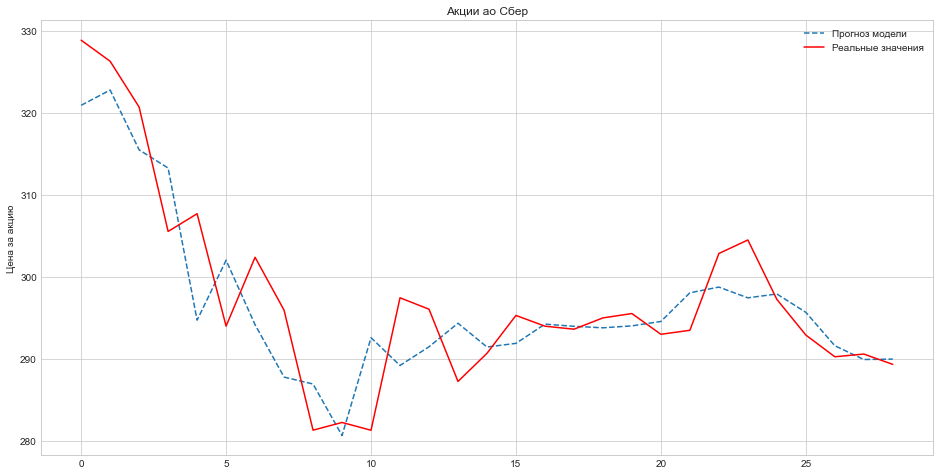

In [340]:
plt.figure(figsize=(16,8))
plt.plot(forecst['AVG'], '--', label='Прогноз модели')
plt.plot(test_data.Close.values, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [341]:
print(f'MAPE : {mean_absolute_percentage_error(test_data.Close, forecst.AVG)}')
print(f'MAE  : {mean_absolute_error(test_data.Close, forecst.AVG)}')
print(f'MSE  : {mean_squared_error(test_data.Close, forecst.AVG)**0.5}')
print(f'R2  : {r2_score(test_data.Close, forecst.AVG)**0.5}')

MAPE : 0.015112895091529265
MAE  : 4.520218906077758
MSE  : 5.71518667026516
R2  : 0.8669296867668189


In [343]:
forecst

,Эксп.сгл,LR,XGB,ARMA,Hybrid,AVG
0,315.471833,326.935408,325.542175,315.660004,320.995894,320.921063
1,328.072490,321.342138,319.521301,328.859985,316.096711,322.778525
2,326.529333,306.106055,307.013580,326.290009,311.507177,315.489231
3,320.757959,307.878128,307.561981,320.700012,309.454142,313.270445
4,304.912047,294.262364,282.312500,305.540009,286.575886,294.720561
5,306.258500,302.156587,298.681793,307.700012,295.317839,302.022946
6,291.738541,296.092686,296.771484,293.989990,292.235961,294.165733
7,300.201654,281.288969,276.389526,302.390015,278.635163,287.781065
8,293.887590,281.659421,280.316315,295.940002,282.884311,286.937528
9,277.003041,280.755877,283.843750,281.309998,280.368393,280.656212


In [342]:
forecst.AVG

0     320.921063
1     322.778525
2     315.489231
3     313.270445
4     294.720561
5     302.022946
6     294.165733
7     287.781065
8     286.937528
9     280.656212
10    292.584544
11    289.195834
12    291.478468
13    294.346245
14    291.451420
15    291.893754
16    294.239960
17    293.973944
18    293.790832
19    294.026789
20    294.564884
21    298.059527
22    298.756411
23    297.445541
24    297.915639
25    295.680474
26    291.605669
27    289.924069
28    289.977140
Name: AVG, dtype: float64